# **Forecasting Realized Volatility**

In contrast to *implied volatility* (IV), which reflects the market’s expectation of future uncertainty, *realized volatility* (RV) corresponds to the volatility that actually materializes over a given horizon. From a modeling perspective, RV exhibits strong persistence and clustering, making it more forecastable than IV or returns themselves.

## Why Forecast Realized Volatility?

Forecasting RV is valuable for several reasons in both trading and risk management:

- **Volatility Trading & IV–RV Strategies**  
  Accurate RV forecasts allow us to identify mispricings between implied and realized volatility.  
  For example, if IV is significantly higher than the forecasted RV, it may indicate an opportunity to short volatility and harvest the volatility risk premium (VRP).

- **Position Sizing**  
  Forecasted volatility can be used to dynamically scale positions: larger sizes in calm regimes, smaller sizes in volatile markets.  
  This volatility targeting improves risk-adjusted returns.

- **Risk Management (Stop Loss / Take Profit)**  
  RV forecasts help set realistic expectations for daily or monthly moves, which can inform stop-loss and take-profit levels in directional strategies.

---

By systematically modeling and forecasting RV — using approaches such as HAR models, GARCH-type processes, or machine learning — we can generate signals that are not only academically robust but also directly actionable in trading strategies.


The notebook is structured as follows:

1. [Read & Prepare Data](#read_data)
2. [Volatility Estimators](#real-vol)
   - [2.1. Historical (close-to-close): 10D, 21D, 100D](#trade-execution-setup)
   - [2.2. Range-based (OHLC): Parkinson, GK, Rogers-Satchel, Yang Zhang](#trade-execution-setup)
   - [2.3. High-Frequency Estimators: Realized Variance](#e)
3. [Stylized facts of realized volatility](#real-vol)
4. [Predictors of realized volatility](#real-vol)
5. [Forecasting Models](#real-vol)
6. [Evaluation: Walk forward with cross val, RMSE vs QLIKE, plotting residuals, refitting models every months](#real-vol)

In [342]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from matplotlib import gridspec

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

pd.options.mode.chained_assignment = None 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **1. Read & Prepare Data**

For this analysis we are going to consider daily S&P500 OHLC data from Yahoo finance from `2018` to `2025` and prepare it for analysis.

In [79]:
spx = yf.download("^GSPC", start="2018-01-01", auto_adjust=True)
spx.columns = spx.columns.droplevel("Ticker")
spx.columns.name = None
spx

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,2695.810059,2695.889893,2682.360107,2683.729980,3397430000
2018-01-03,2713.060059,2714.370117,2697.770020,2697.850098,3544030000
2018-01-04,2723.989990,2729.290039,2719.070068,2719.310059,3697340000
2018-01-05,2743.149902,2743.449951,2727.919922,2731.330078,3239280000
2018-01-08,2747.709961,2748.510010,2737.600098,2742.669922,3246160000
...,...,...,...,...,...
2025-10-20,6735.129883,6744.350098,6690.049805,6690.049805,4672170000
2025-10-21,6735.350098,6752.160156,6722.029785,6736.750000,5245020000
2025-10-22,6699.399902,6741.750000,6655.689941,6741.339844,5710010000


In [84]:
spx.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [86]:
spx["returns"] = np.log(spx["Close"] / spx["Close"].shift(1))
spx = spx.dropna()
spx

,Close,High,Low,Open,Volume,returns
Date,,,,,,
2018-01-03,2713.060059,2714.370117,2697.770020,2697.850098,3544030000,0.006378
2018-01-04,2723.989990,2729.290039,2719.070068,2719.310059,3697340000,0.004021
2018-01-05,2743.149902,2743.449951,2727.919922,2731.330078,3239280000,0.007009
2018-01-08,2747.709961,2748.510010,2737.600098,2742.669922,3246160000,0.001661
2018-01-09,2751.290039,2759.139893,2747.860107,2751.149902,3467460000,0.001302
...,...,...,...,...,...,...
2025-10-20,6735.129883,6744.350098,6690.049805,6690.049805,4672170000,0.010616
2025-10-21,6735.350098,6752.160156,6722.029785,6736.750000,5245020000,0.000033
2025-10-22,6699.399902,6741.750000,6655.689941,6741.339844,5710010000,-0.005352


Text(0.5, 1.0, 'Log Returns')

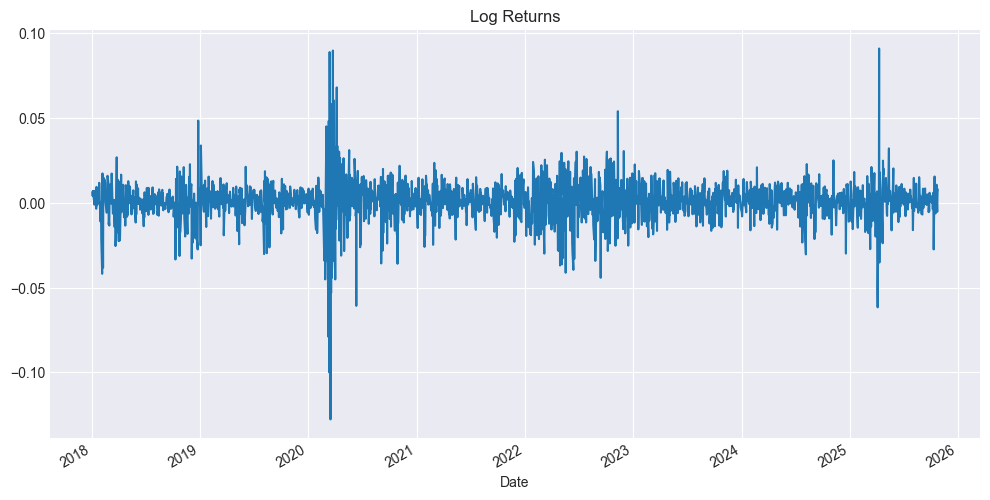

In [87]:
spx["returns"].plot(figsize=(12, 6))
plt.title("Log Returns")

# **2. Volatility Estimators**

Volatility is a *latent* quantity — it cannot be observed directly. To evaluate forecasts and build predictors, we need to construct **proxies** from price data. Different estimators trade off bias vs efficiency depending on the sampling frequency and data available.

## 2.1 Historical / Close-to-Close

The simplest approach uses only closing price data and is often called the **close-to-close estimator**.   It computes realized volatility from consecutive daily returns. This estimator serves as a useful **benchmark**, but it suffers from several drawbacks: it ignores intraday variation, overnight jumps, and the information contained in opening, high, and low prices, which often makes it downward biased.

Formally, over a horizon $H$:

$$
RV_{t,H} = \sqrt{\tfrac{252}{H} \sum_{j=1}^H r_{t+j}^2}, 
\quad r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

In [88]:
def rv_close_to_close(returns, h=21, ann=252):
    var = returns.pow(2).rolling(h).sum() * (ann / h)
    return np.sqrt(var)

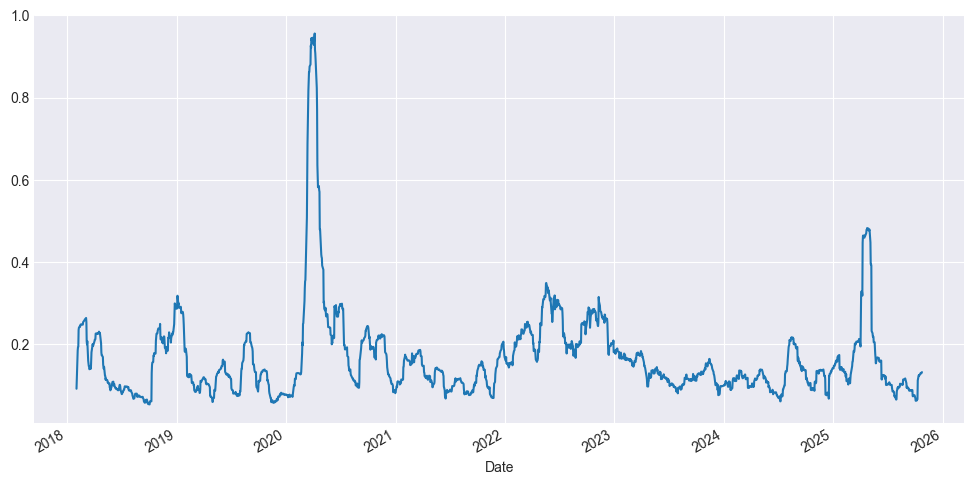

In [ ]:
spx["rv_close"] = rv_close_to_close(spx["returns"], h=21)
spx["rv_close"].plot(figsize=(12, 6))
plt.show()

## 2.2 Range-Based Proxies (OHLC)

Instead of relying only on closing prices, we can extract more information from each trading day by incorporating the **Open, High, Low, and Close (OHLC)** prices.  
Over the years, several range-based estimators have been proposed, each addressing specific shortcomings of the close-to-close method and earlier estimators.  
These approaches typically reduce variance in the volatility estimate and account for intraday dynamics, but each comes with its own assumptions and limitations.

### 2.2.1 Parkinson Estimator

The **Parkinson (1980) estimator** uses the daily high–low range to capture intraday price variability.  
By relying on the full range rather than just closing prices, it provides a more efficient estimate of volatility under the assumption of a **driftless geometric Brownian motion**.  

However, it ignores opening and closing prices and is highly sensitive to jumps or bid–ask bounce at the extremes of the trading day.

Formally, over a horizon $H$:

$$
RV^{\text{Parkinson}}_{t,H} 
= \sqrt{ \frac{252}{4H \ln(2)} \sum_{j=1}^H \left[ \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right]^2 }
$$

In [90]:
def rv_parkinson(high, low, h=21, ann=252):
    rp = np.log(high / low).pow(2)  # per-day range variance proxy
    var = rp.rolling(h, min_periods=h).sum() * (ann / (4 * np.log(2) * h))
    return np.sqrt(var)

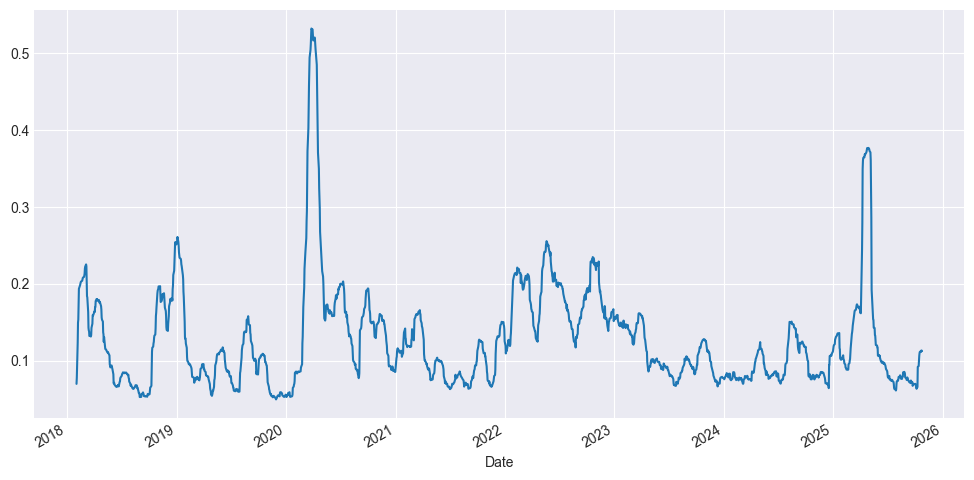

In [ ]:
spx["rv_parkinson"] = rv_parkinson(spx["High"], spx["Low"], h=21)
spx["rv_parkinson"].plot(figsize=(12, 6))
plt.show()

### 2.2.2 Garman–Klass Estimator

The **Garman–Klass (1980) estimator** improves upon the Parkinson measure by incorporating not only the daily high and low, but also the open and close prices.  
This allows it to capture more information about intraday price variation and reduce estimation variance under the assumption of a driftless geometric Brownian motion.  

However, like the Parkinson estimator, it can be biased in the presence of significant drift or opening jumps, since it assumes zero drift and continuous trading.

Formally, over a horizon $H$:

$$
RV^{\text{GK}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ \tfrac{1}{2} \left( \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right)^2 
- (2\ln(2) - 1) \left( \ln\!\left(\tfrac{C_{t+j}}{O_{t+j}}\right) \right)^2 
\right] }
$$

In [92]:
def rv_garman_klass(open_, high, low, close, h=21, ann=252):
    # Daily GK variance (no drift)
    rs = 0.5 * (np.log(high/low).pow(2)) - (2*np.log(2) - 1) * (np.log(close/open_).pow(2))
    var = rs.rolling(h).sum() * (ann / h)
    return np.sqrt(var)

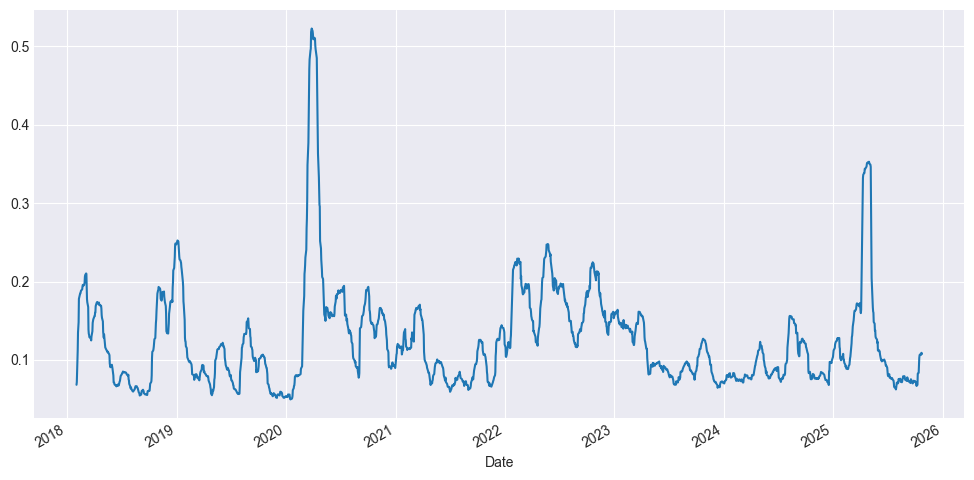

In [ ]:
spx["rv_gk"] = rv_garman_klass(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_gk"].plot(figsize=(12, 6))
plt.show()

### 2.2.3 Rogers–Satchell Estimator

The **Rogers–Satchell (1991) estimator** was introduced to overcome one of the limitations of the Parkinson and Garman–Klass estimators: their assumption of zero drift.  
The Rogers–Satchell measure is **drift-robust**, making it better suited for assets that experience trending behavior.  
It uses all four OHLC prices, but in a different functional form that explicitly accommodates nonzero expected returns.  

While it handles drift effectively, it remains sensitive to microstructure noise and extreme jumps at the open or close.

Formally, over a horizon $H$:

$$
RV^{\text{RS}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ 
\ln\!\left(\tfrac{H_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{H_{t+j}}{O_{t+j}}\right) 
+ \ln\!\left(\tfrac{L_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{L_{t+j}}{O_{t+j}}\right) 
\right] }
$$

In [94]:
def rv_rogers_satchell(open_, high, low, close, h=21, ann=252):
    term1 = np.log(high/close) * np.log(high/open_)
    term2 = np.log(low/close) * np.log(low/open_)
    rs = (term1 + term2)
    var = rs.rolling(h).sum() * (ann/h)
    return np.sqrt(var)

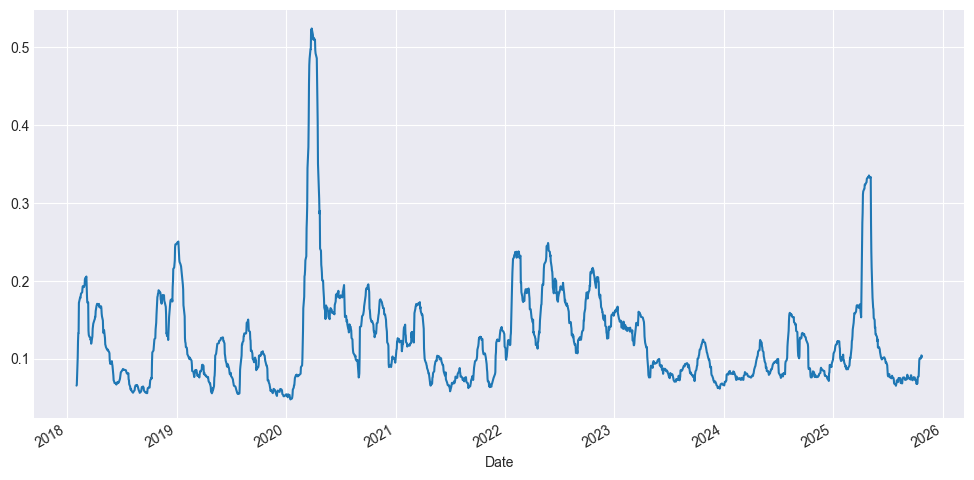

In [ ]:
spx["rv_rs"] = rv_rogers_satchell(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_rs"].plot(figsize=(12, 6))
plt.show()

### 2.2.4 Yang–Zhang Estimator

The **Yang–Zhang (2000) estimator** combines the advantages of previous methods by incorporating overnight variance, open-to-close variance, and the Rogers–Satchell range-based component.  
It is **unbiased in the presence of drift**, less sensitive to opening jumps, and has significantly lower estimation variance compared to Parkinson, Garman–Klass, or Rogers–Satchell taken alone.  

This makes Yang–Zhang one of the most efficient daily volatility estimators available when OHLC data are present.

Formally, the daily Yang–Zhang variance can be expressed as:

$$
\sigma^2_{YZ} = \sigma^2_O + k \, \sigma^2_C + (1-k)\, \sigma^2_{RS}
$$

where  
- $\sigma^2_O = \big( \ln(O_t / C_{t-1}) \big)^2$ is the overnight variance,  
- $\sigma^2_C = \big( \ln(C_t / O_t) \big)^2$ is the open-to-close variance,  
- $\sigma^2_{RS}$ is the Rogers–Satchell variance component,  
- $k \approx 0.34$ is a weight chosen to minimize bias and variance.  

Aggregating over a horizon $H$:

$$
RV^{\text{YZ}}_{t,H} = \sqrt{ \frac{252}{H} \sum_{j=1}^H \sigma^2_{YZ,\,t+j} }
$$

In [96]:
def rv_yang_zhang(open_, high, low, close, h=21, ann=252, k=0.34):
    # Overnight return variance
    oc = np.log(open_/close.shift(1))
    sigma_o = oc.pow(2)

    # Open-to-close variance
    co = np.log(close/open_)
    sigma_c = co.pow(2)

    # Rogers–Satchell component
    rs = (
        np.log(high/close) * np.log(high/open_) +
        np.log(low/close) * np.log(low/open_)
    )

    # Daily YZ variance
    yz = sigma_o + k*sigma_c + (1-k)*rs

    var = yz.rolling(h, min_periods=h).sum() * (ann/h)
    return np.sqrt(var)

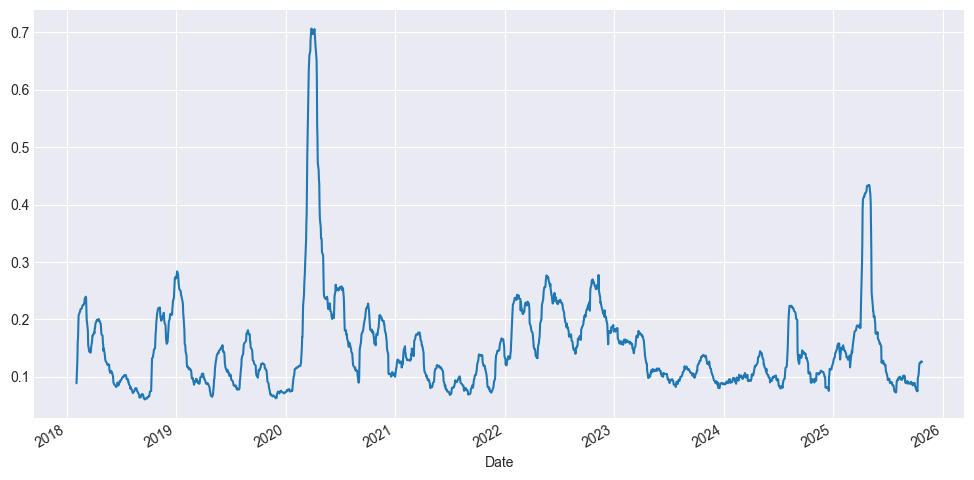

In [ ]:
spx["rv_yz"] = rv_yang_zhang(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_yz"].plot(figsize=(12, 6))
plt.show()

## 2.3 Which Estimator to choose ?

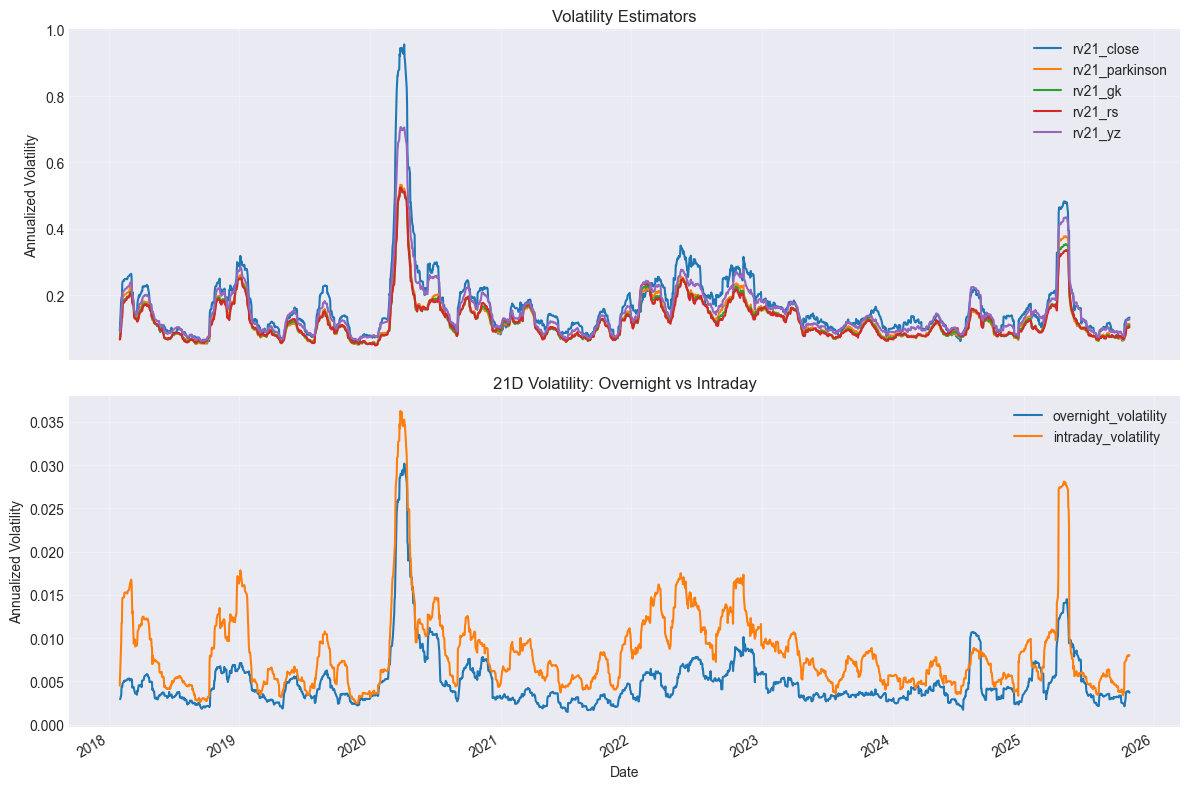

In [111]:
spx["overnight_volatility"] = np.log(spx["Open"] / spx["Close"].shift(1)).rolling(21).std()
spx["intraday_volatility"] = np.log(spx["Close"] / spx["Open"]).rolling(21).std()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- top panel: volatility estimators ---
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax1)
ax1.set_title("Volatility Estimators")
ax1.set_ylabel("Annualized Volatility")
ax1.grid(alpha=0.3)
ax1.legend()

# --- bottom panel: overnight vs intraday volatility ---
spx[["overnight_volatility", "intraday_volatility"]].plot(ax=ax2)
ax2.set_title("21D Volatility: Overnight vs Intraday")
ax2.set_ylabel("Annualized Volatility")
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

- **Insight:** You’ll see that in stress regimes (e.g., 2008, COVID-19 crash), *overnight moves dominate*. YZ explicitly accounts for this.

### 2.3 High-Frequency Estimators: Realized Variance

With **5-minute high-frequency data**, we can incorporate much more intraday information than when relying only on daily OHLC data.  
In this notebook, we use **E-mini S&P 500 futures (ES)**, which trade almost 24 hours a day, so the realized measure naturally includes overnight returns as well.  

The choice of a 5-minute sampling grid is widely recognized as the best trade-off between capturing information and avoiding microstructure distortions: it explains about **90–95% of daily integrated variance**. At higher frequencies (e.g., 1-min, tick), **microstructure noise**—such as bid–ask bounce and discrete price jumps—becomes more prominent, requiring more advanced techniques (e.g., **pre-averaged RV** or **realized kernels**).  

As a baseline, we consider the **realized variance (RV)** estimator, defined over a day $t$ with intraday returns $r_{t,i}$ as:

$$
RV_t = \sum_{i=1}^{N_t} r_{t,i}^2,
\quad 
r_{t,i} = \ln\!\left(\frac{P_{t,i}}{P_{t,i-1}}\right)
$$

where $N_t$ is the number of 5-minute intervals within day $t$, and $P_{t,i}$ denotes the price at interval $i$.

In [142]:
es_5min = pd.read_csv("data/intermediate/es-5m.csv", 
                 sep=";", 
                 header=None,
                 names=["date","time","open","high","low","close","volume"])

es_5min["datetime"] = pd.to_datetime(es_5min["date"] + " " + es_5min["time"], 
                                     format="%d/%m/%Y %H:%M:%S")

es_5min = es_5min.drop(columns=["date","time"]).set_index("datetime").sort_index()

es_5min = es_5min.loc["2018":]
es_5min

,open,high,low,close,volume
datetime,,,,,
2018-01-01 17:00:00,2675.25,2678.75,2674.50,2678.50,6551
2018-01-01 17:05:00,2678.25,2679.25,2677.25,2679.00,2074
2018-01-01 17:10:00,2678.75,2679.25,2678.25,2679.25,1749
2018-01-01 17:15:00,2679.00,2679.75,2679.00,2679.50,871
2018-01-01 17:20:00,2679.25,2679.50,2679.25,2679.25,440
...,...,...,...,...,...
2025-10-21 23:35:00,6785.75,6786.25,6785.00,6785.25,170
2025-10-21 23:40:00,6785.25,6786.75,6785.25,6786.25,224
2025-10-21 23:45:00,6786.25,6786.50,6783.25,6783.75,729


In [148]:
es_5min.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [158]:
es_5min[es_5min.index.duplicated(keep=False)]

,open,high,low,close,volume
datetime,,,,,
2023-09-03 23:55:00,4522.00,4522.25,4521.75,4522.25,77
2023-09-03 23:55:00,4522.00,4522.25,4521.75,4522.25,77
2023-12-11 23:55:00,4628.00,4628.00,4627.75,4628.00,23
2023-12-11 23:55:00,4628.00,4628.00,4627.75,4628.00,23
2024-07-25 00:00:00,5482.75,5483.50,5482.00,5483.50,483
...,...,...,...,...,...
2024-07-25 23:45:00,5465.25,5466.50,5465.25,5466.00,304
2024-07-25 23:50:00,5466.25,5466.75,5465.50,5466.25,385
2024-07-25 23:50:00,5466.25,5466.75,5465.50,5466.25,385


In [159]:
es_5min = es_5min[~es_5min.index.duplicated(keep="last")]

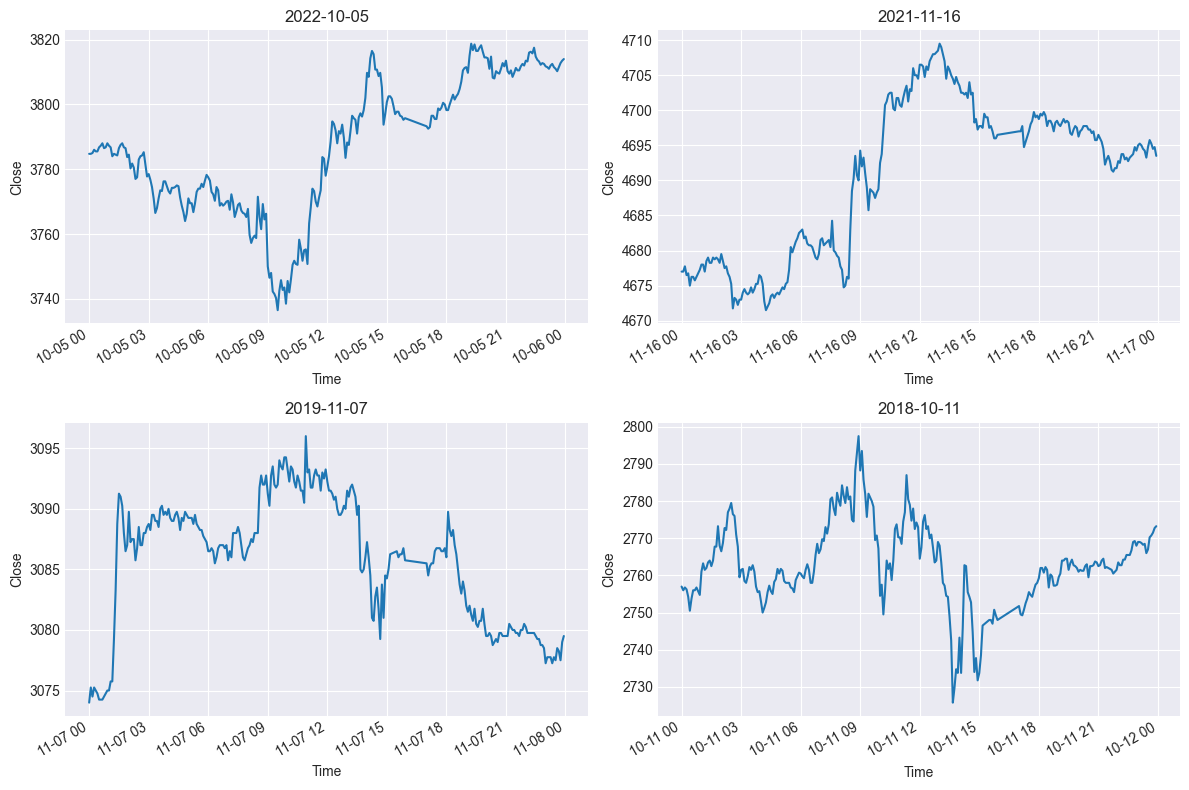

In [ ]:
# pick 4 random days
all_days = es_5min.index.normalize().unique().date
days = np.random.choice(all_days, size=4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, day in zip(axes.ravel(), days):
    es_5min.loc[str(day), "close"].plot(ax=ax)
    ax.set_title(day.strftime("%Y-%m-%d"))
    ax.set_xlabel("Time")
    ax.set_ylabel("Close")

plt.tight_layout()
plt.show()

There are some interpolated prices, but oeverall teh quality looks good comapred to yfinance for isnatcne where msot of the series would be interpolated.

In [287]:
def daily_realized_variance(close) -> pd.Series:
    """
    Compute daily realized variance from intraday data:
        RV_t = sum_i r_{t,i}^2, where r_{t,i} = log(P_{t,i}/P_{t,i-1})
    """
    # intraday log returns
    r = np.log(close).diff()

    # sum of squared intraday returns by day
    rv_daily = r.pow(2).groupby(close.index.date).sum()
    rv_daily.index = pd.to_datetime(rv_daily.index)
    rv_daily.name = "var_daily"

    return rv_daily

def realized_volatility(
    close: pd.DataFrame,
    h: int = 21,
    ann: int = 252,
    rth_start: str = "09:30",
    rth_end: str = "16:00",
) -> pd.Series:
    """
    Compute h-day realized variance/volatility from intraday prices.
    """
    tod = close.index.strftime("%H:%M")
    rth = close[(tod >= rth_start) & (tod <= rth_end)].copy()

    # RTH intraday returns & variance
    r = np.log(rth["close"]).diff()
    var_rth = r.pow(2).groupby(rth.index.date).sum()
    var_rth.index = pd.to_datetime(var_rth.index)
    var_rth = var_rth.sort_index().rename("var_rth")

    # h-day annualized realized volatility
    rv = np.sqrt(var_rth.rolling(h).sum() * (ann / h)).rename(f"rv{h}_ann")

    return rv

In [ ]:
es_rv_21 = realized_volatility(es_5min["close"], h=21)

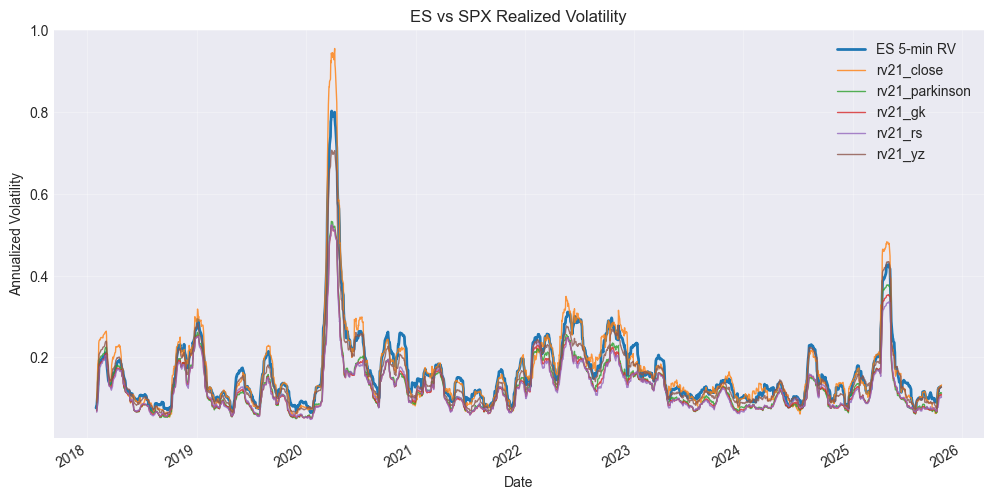

In [260]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

es_rv_21.plot(ax=ax, label="ES 5-min RV", lw=2)
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax, lw=1, alpha=0.8)

ax.set_title("ES vs SPX Realized Volatility")
ax.set_ylabel("Annualized Volatility")
ax.grid(alpha=0.3)
ax.legend()

plt.show()

The difference between close-to-close and realized variance is evne more pormiennt at daily frequency.

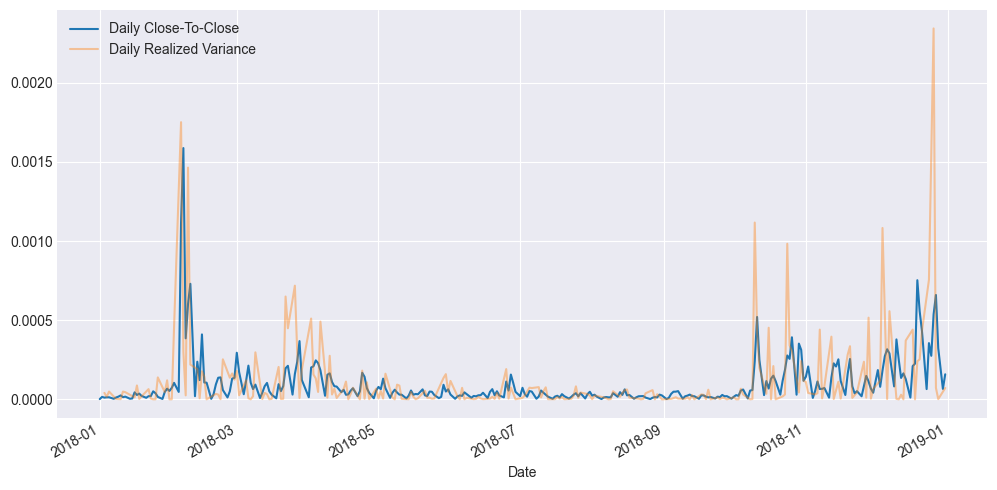

In [300]:
daily_rv = daily_realized_variance(es_5min["close"])
daily_c2c = spx["returns"].pow(2)

plt.figure(figsize=(12, 6))
daily_rv.loc["2018"].plot(alpha=1, label="Daily Close-To-Close")
daily_c2c.loc["2018"].plot(alpha=0.4, label="Daily Realized Variance")
plt.legend()
plt.show()

Her eteh close-toc-lsoe is much nosiier than teh realieed variance which cpatures daily variatiosn more smoothly.

# **3. Stylized facts of volatility**

Here we will be investgating stylized facts of daily volatility that can be used for modelling perspective. The idea is to highlight the key charcetristics of daily varaicne that can be leveraged to forecast the future volaitltiy. From a modellign perspective it is betetr to work diertcly with varaicne instea dof std (isnce variance is additive) as well as dealing with the daily one isnetad of teh monthyl rollign one (which does not align with the stylized fatcs which come from daily frequency).

Volatility us 

- ACF-PACF of saurred returns (persistence)
- Volatiltiy clusterign & Mean reversion
- Leverage effect

In [ ]:
daily_rv = daily_realized_variance(es_5min["close"])
daily_c2c = spx["returns"].pow(2)

## 3.1 Volatility clustering

It is the msot important phenomena as volatility is not constant, it evolves in low and high volatility regimes respecitvely. The idea is that high (resp. low) level of voalitlities tend to be follwoed by high (resp. low) level of volaitlity respectievly.

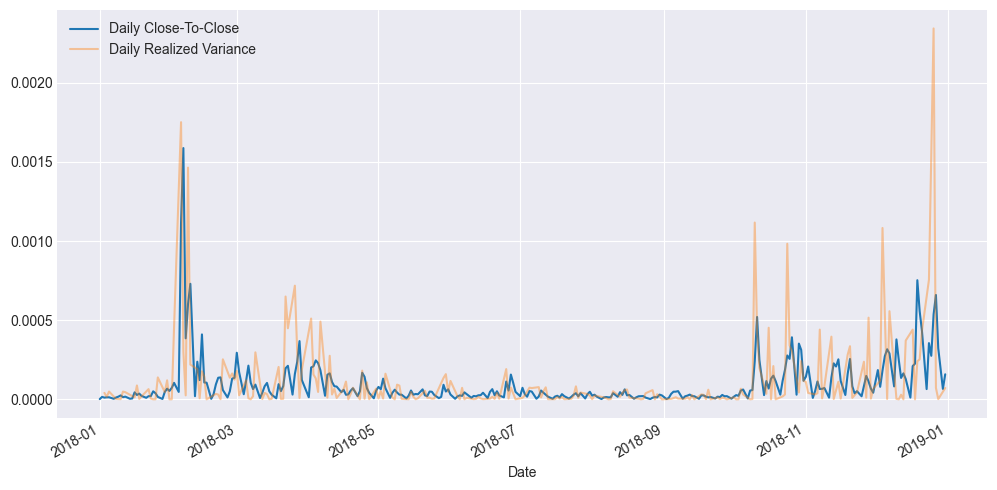

In [301]:
daily_rv = daily_realized_variance(es_5min["close"])
daily_c2c = spx["returns"].pow(2)

plt.figure(figsize=(12, 6))
daily_rv.loc["2018"].plot(alpha=1, label="Daily Close-To-Close")
daily_c2c.loc["2018"].plot(alpha=0.4, label="Daily Realized Variance")
plt.legend()
plt.show()

## 3.2 Long Memory / Slow Decay

Squarred retursn and realized varaicne show strong persiteenc eover many lags. Means today’s volatility has predictive power even months ahead. Thi smotivates the use of HAR-RV models that parsimuniusly include many lags until monthyl lags.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=40, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    axes[0].set_title(f"ACF {title}")

    plot_pacf(series.dropna(), lags=lags, ax=axes[1], method="ywm")  # Yule-Walker-M estimator
    axes[1].set_title(f"PACF {title}")

    plt.tight_layout()
    plt.show()

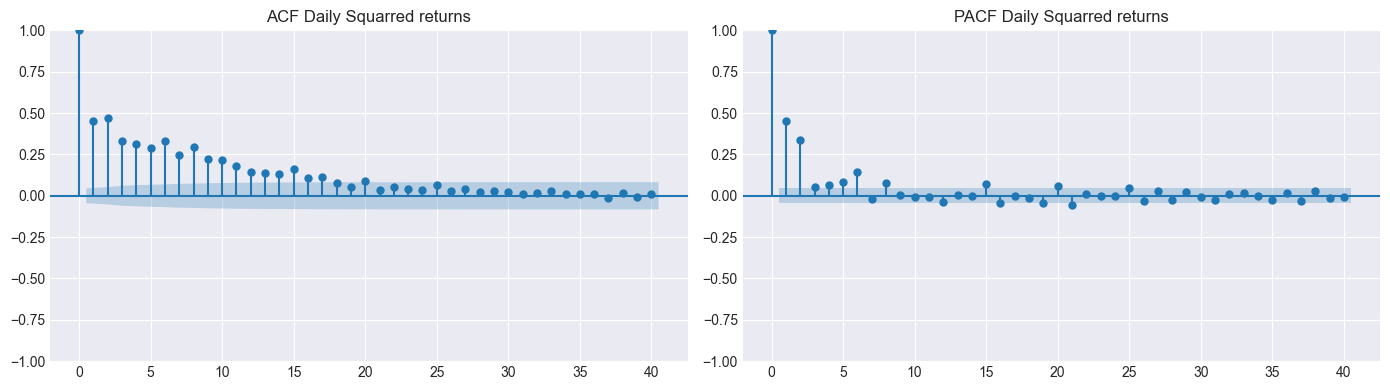

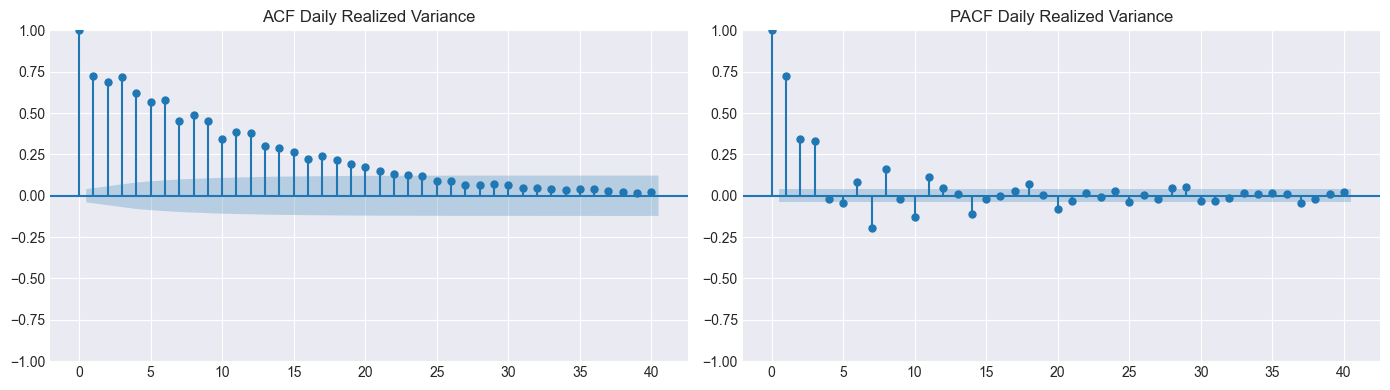

In [304]:
plot_acf_pacf(daily_c2c, lags=40, title="Daily Squarred returns")
plot_acf_pacf(daily_rv, lags=40, title="Daily Realized Variance")

For short horizons, the realized varaicne is more persitent than the close-to-close appromxiated by squarred returns with lags which ate meaningful until 1 months thus we could use autoregressive terms until the 21th to forecast teh next day volatility.

## 3.3 Mean-reverting behaviour

In [317]:
from statsmodels.tsa.ar_model import AutoReg

# Fit AR(1) model
model = AutoReg(daily_rv.to_numpy(), lags=1, old_names=False)
res = model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2431
Model:                     AutoReg(1)   Log Likelihood               16689.010
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Sun, 26 Oct 2025   AIC                         -33372.019
Time:                        15:50:11   BIC                         -33354.632
Sample:                             1   HQIC                        -33365.698
                                 2431                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.451e-05    5.4e-06      6.389      0.000    2.39e-05    4.51e-05
y.L1           0.7264      0.014     52.109      0.000       0.699       0.754
                                    Roots           

The regression coefficient sugguest that the variance has mean-reverting property that can be leveraged in autoregression mdoel like **GARCH**

## 3.4 Volatility distributions are often log-normal

Volatility is strictly positive, highly right-skewed, and empirically close to **log-normal**.  
In other words, while raw volatility (RV, IV) has a heavy-tailed distribution,  
its logarithm is much closer to Normal.

**Modeling benefits:**
- **Positivity:** By modeling log-volatility and exponentiating back, forecasts are guaranteed ≥ 0.  
- **Better fit:** Log-volatility is closer to Gaussian → forecast errors are more symmetric and homoscedastic.  
- **Statistical validity:** Standard linear models (ARMA, HAR-RV, regressions) work more reliably on log-volatility.  

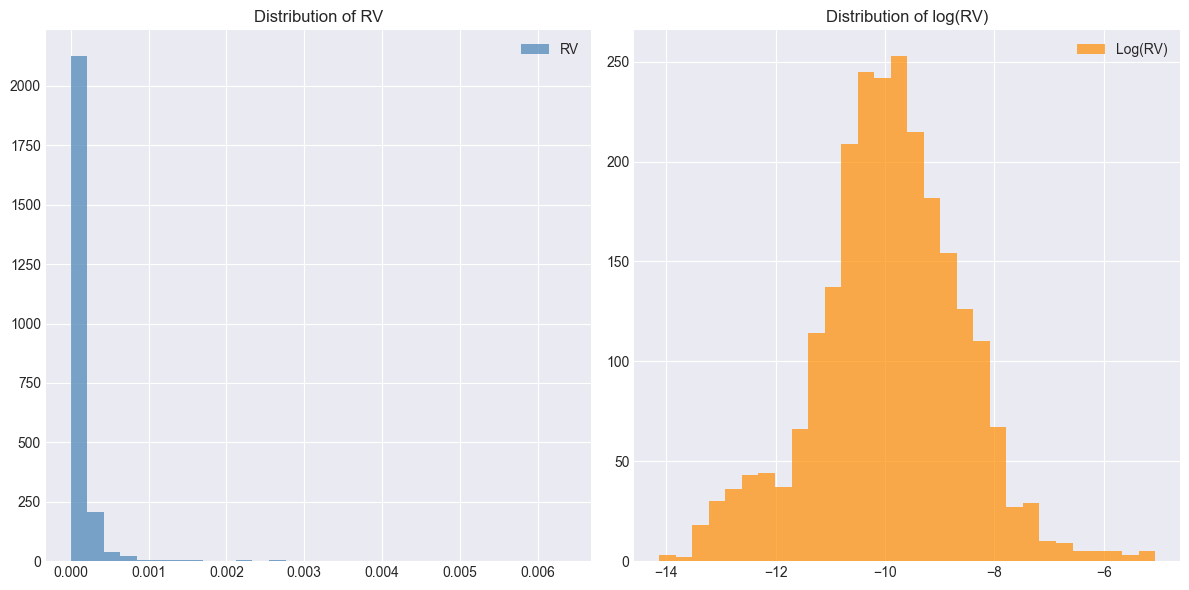

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

daily_rv.hist(bins=30, ax=axes[0], label="RV", color="steelblue", alpha=0.7)
axes[0].set_title("Distribution of RV")
axes[0].legend()

np.log(daily_rv).hist(bins=30, ax=axes[1], label="Log(RV)", color="darkorange", alpha=0.7)
axes[1].set_title("Distribution of log(RV)")
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.5 Asymmetry / Leverage Effect

Another key stylized fact is the **asymmetric relation between returns and volatility**:  
- Negative returns (price drops) tend to increase future volatility more than positive returns of the same magnitude.  
- This is often called the **leverage effect**, since a fall in equity prices increases financial leverage, making the firm riskier.  
- In practice, this creates an asymmetric volatility–return correlation:
  - Correlation between returns and future volatility < 0.

**Modeling implications:**
- Symmetric models (e.g., standard GARCH) cannot capture this.  
- Asymmetric extensions such as EGARCH, GJR-GARCH, or stochastic volatility with leverage are used to account for it.  

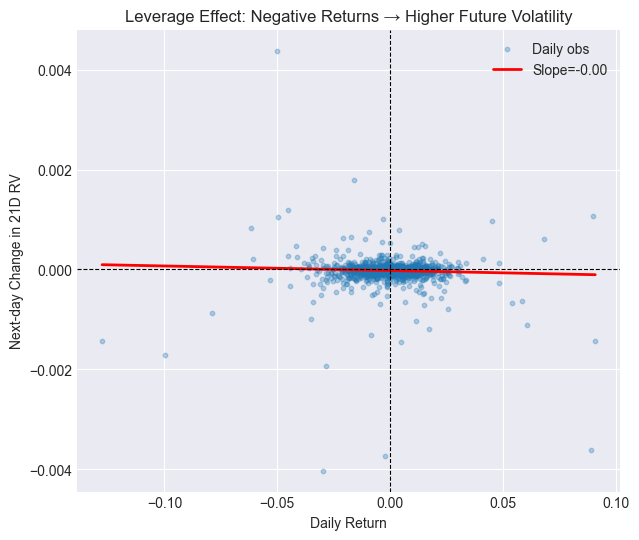

In [327]:
# --- Next-day change in volatility ---
dvol = daily_rv.shift(-1) - daily_rv   # Δvol at t+1

# Align
df = pd.concat([spx["returns"], dvol], axis=1).dropna()
df.columns = ["ret", "dvol"]

# --- Scatterplot ---
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(df["ret"], df["dvol"], alpha=0.3, s=10, label="Daily obs")

# Fit regression line
m, b = np.polyfit(df["ret"], df["dvol"], 1)
x_vals = np.linspace(df["ret"].min(), df["ret"].max(), 100)
ax.plot(x_vals, m*x_vals + b, color="red", lw=2, label=f"Slope={m:.2f}")

# Axes + titles
ax.axhline(0, color="black", ls="--", lw=0.8)
ax.axvline(0, color="black", ls="--", lw=0.8)
ax.set_xlabel("Daily Return")
ax.set_ylabel("Next-day Change in 21D RV")
ax.set_title("Leverage Effect: Negative Returns → Higher Future Volatility")
ax.legend()

plt.show()

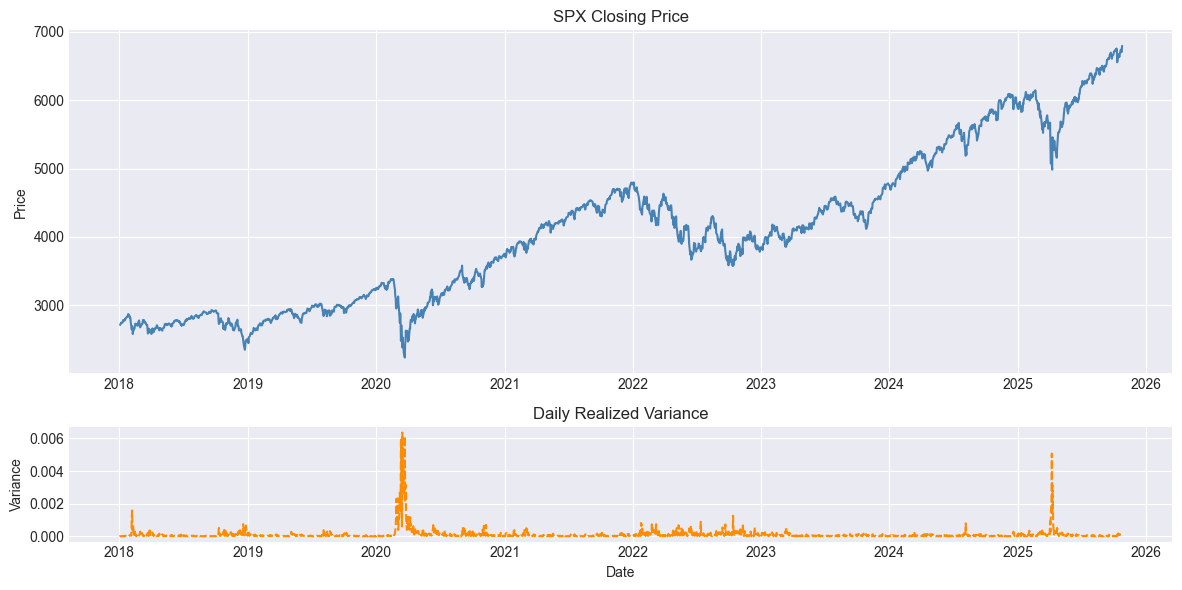

In [ ]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # top 3x bigger than bottom

# Top: SPX closing price
ax1 = fig.add_subplot(gs[0])
ax1.plot(spx.index, spx["Close"], color="steelblue")
ax1.set_title("SPX Closing Price")
ax1.set_ylabel("Price")

# Bottom: realized volatility
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(daily_rv.index, daily_rv, color="darkorange", linestyle="--")
ax2.set_title("Daily Realized Variance")
ax2.set_ylabel("Variance")
ax2.set_xlabel("Date")

plt.tight_layout()
plt.show()

Here we can see that durign stress regimes voalitltiy tend to spike.

# **4. Predictors of realized volatility**

- HAR lags
- ATM 30D IV (or VIX) (HAR-IV)
- Overnigth returns (HAR-O)
- Downisde smei variance/assymetry (HAR-L)
- Vol of RV (HAR-GARCH)
- VIX term strcuture, VVIX

# **4. Forecast Realized Volatility**

In [15]:
from abc import ABC, abstractmethod

class BaseRVForecaster(ABC):
    def __init__(self, H=21, name=None):
        self.H = H
        self.name = name or self.__class__.__name__

    @abstractmethod
    def fit(self, returns: pd.Series, rv: pd.Series, **kwargs):
        """Estimate parameters using a TRAIN window (no look-ahead)."""

    def warm_state(self, returns: pd.Series, rv: pd.Series):
        """Update internal state with observed data (no parameter re-fit)."""
        return self

    @abstractmethod
    def forecast(self, as_of_index: pd.DatetimeIndex) -> pd.Series:
        """Return ex-ante H-horizon RV forecast indexed by as_of_index."""


## **4.1 EWMA (Risk Metrics)**

## **4.1 Log HAR-RV**

## **4.1 GARCH family of models (GARCH(1, 1), EGARCH, GJR-GARCH)**

## **4.1 Machine Learning models (Random Forest, XGboost)**

## **4.1 Ensemble Model**

Take the best model of each family and create an esnbmel fo predicitons. Either simple average prediciton, or weighted preidction 1/RMSE, bayesian modelling of the weights, kalman filters for dynamic parameters, markov-swithcing models in low vs high volaility regimes.
Once a model is chsoen for a given family keep it for the all testing, jsut update the weights dinamically and refit the mdoel every month or week. 
For HAR and GARCH family of models, can use AIC and QLIKE as well as LR tets for incremental parameters.

In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from arch import arch_model
from sklearn.ensemble import GradientBoostingRegressor

class RVForecaster:
    def __init__(self, returns, rv):
        """
        Parameters
        ----------
        returns : pd.Series
            Daily log returns of the underlying.
        rv : pd.Series
            Realized volatility series (e.g. 21D rolling, annualized).
        """
        self.returns = returns.dropna()
        self.rv = rv.dropna()
    
    # === EWMA ===
    def ewma(self, lam=0.94):
        """RiskMetrics EWMA volatility forecast."""
        sigma2 = 0
        forecasts = []
        for r in self.returns:
            sigma2 = lam * sigma2 + (1 - lam) * r**2
            forecasts.append(np.sqrt(sigma2 * 252))
        return pd.Series(forecasts, index=self.returns.index, name="EWMA")
    
    # === HAR-RV ===
    def har(self, lags=(1,5,22)):
        """HAR-RV model using daily/weekly/monthly realized vol."""
        df = pd.DataFrame({"RV": self.rv})
        for lag in lags:
            df[f"lag{lag}"] = self.rv.shift(lag).rolling(lag).mean()
        df = df.dropna()
        X = sm.add_constant(df[[f"lag{l}" for l in lags]])
        model = OLS(df["RV"], X).fit()
        forecast = model.predict(X)
        return forecast.rename("HAR-RV")
    
    # === GARCH(1,1) ===
    def garch(self):
        """GARCH(1,1) forecast."""
        model = arch_model(self.returns*100, vol="GARCH", p=1, q=1, dist="normal")
        res = model.fit(disp="off")
        forecast = res.forecast(horizon=1).variance.iloc[:,0]**0.5 / 100
        forecast = forecast.rename("GARCH(1,1)")
        return forecast
    
    # === ML (GBM by default) ===
    def ml(self, features, model=None):
        """Forecast RV using ML (GradientBoosting by default)."""
        if model is None:
            model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        X = features.shift(1).dropna()
        y = self.rv.loc[X.index]
        model.fit(X, y)
        forecast = pd.Series(model.predict(X), index=X.index, name="ML-RV")
        return forecast

ModuleNotFoundError: No module named 'arch'